# Introduction: State-Space Methods for Controller Design

In this section, we will show how to design controllers and observers using state-space (or time-domain) methods.

## Modeling

There are several different ways to describe a system of linear differential equations.  The **state-space representation** was introduced in the [Introduction: System Modeling](../Introduction/Introduction-SystemModeling.ipynb) section.  For a SISO LTI system, the state-space form is given below:

$$
\frac{d\mathbf{x}}{dt} = A\mathbf{x} + Bu
$$



$$
y = C\mathbf{x} + Du
$$

where **x** is a n by 1 vector representing the state (commonly position and velocity variable in mechanical systems), $u$ is a scalar representing the input (commonly a force or torque in mechanical systems), and $y$ is a scalar representing the output.  The matrices A (n by n), B (n by 1), and C (1 by n) determine the relationships between the state and input and output variables.  Note that there are n first-order differential equations.  State space representation can also be used for systems with multiple inputs and outputs (MIMO), but we will only use single-input, single-output (SISO) systems in these tutorials. To introduce the state space design method, we will use the magnetically suspended ball as an example.  The current through the coils induces a magnetic force which can balance the force of gravity and cause the ball (which is made of a magnetic material) to be suspended in midair.  The modeling of this system has been established in many control text books (including [_Automatic Control Systems_ by B. C. Kuo](https://www.amazon.com/s?k=978-0130548429))
![StateSpaceTutorial_StateSpaceEquations_MagneticModel.png](figures/StateSpaceTutorial_StateSpaceEquations_MagneticModel.png)
The equations for the system are given by:

$$
M\frac{d^2h}{dt^2} = Mg - \frac{Ki^2}{h}
$$



$$
V = L\frac{di}{dt} + iR
$$

where $h$ is the vertical position of the ball, $i$ is the current through the electromagnet, $V$ is the applied voltage, $M$ is the mass of the ball, $g$ is gravity, $L$ is the inductance, $R$ is the resistance, and $K$ is a coefficient that determines the magnetic force exerted on the ball.  

For simplicity, we will choose values:

- `M = 0.05 Kg`
- `K = 0.0001`
- `L = 0.01 H`
- `R = 1 Ohm`
- `g = 9.81 m/sec^2`

The system is at equilibrium (the ball is suspended in midair) whenever $h = K i^2/Mg$ (at which point $dh/dt = 0$).  We linearize the equations about the point $h = 0.01 m$ (where the nominal current is about 7 amp) and get the state space equations:

$$
\frac{d\vec{x}}{dt} = A\vec{x} + Bu
$$



$$
y = C\vec{x} + Du
$$

where:

$$
x = \left[{\begin{array}{c} \Delta h \\ \Delta \dot{h} \\ \Delta i \end{array}}\right]
$$

is the set of state variables for the system (a 3x1 vector), $u$ is the input voltage (delta $V$), and $y$ (the output), is delta $h$.

In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
A = np.array([[0, 1, 0], [980, 0, -2.8], [0, 0, -100]])
B = np.array([[0], [0], [100]])
C = np.array([[1, 0, 0]])

### Stability

One of the first things we want to do is analyze whether the open-loop system (without any control) is stable.  As discussed in the [Introduction: System Analysis](../Introduction/Introduction-SystemAnalysis.ipynb) section, the eigenvalues of the system matrix, A, (equivalent to the poles of the transfer fucntion) determine the stability. The eigenvalues of the A matrix are the values of $s$ where $det(sI - A) = 0$.

In [3]:
poles, _ = np.linalg.eig(A)
poles

array([  31.30495168,  -31.30495168, -100.        ])

From inspection, it can be seen that one of the poles is in the right-half plane (i.e. has positive real part), which means that the open-loop system is unstable.

To observe what happens to this unstable system when there is a non-zero initial condition, add the following lines to your m-file and run it again: 

In [4]:
# Time vector
t = np.arange(0, 2, 0.01)
# Zero Input
u = np.zeros(np.shape(t))
# Initial Conditions: 0.01m, 0 m/s, 0 m/s^2
x0 = np.array([0.01, 0, 0])

In [5]:
sys = control.ss(A, B, C, 0)
sys

StateSpace(array([[   0. ,    1. ,    0. ],
       [ 980. ,    0. ,   -2.8],
       [   0. ,    0. , -100. ]]), array([[  0.],
       [  0.],
       [100.]]), array([[1., 0., 0.]]), array([[0.]]))

Text(0, 0.5, 'Ball Position (m)')

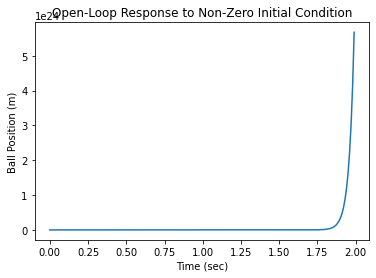

In [6]:
_, y, _ = control.forced_response(sys, T=t, U=u, X0=x0)
plt.plot(t, y)
plt.title("Open-Loop Response to Non-Zero Initial Condition")
plt.xlabel("Time (sec)")
plt.ylabel("Ball Position (m)");

It looks like the distance between the ball and the electromagnet will go to infinity, but probably the ball hits the table or the floor first (and also probably goes out of the range where our linearization is valid).

### Controllability and Observability

A system is **controllable** if there exists a control input, u(t), that transfers any state of the system to zero in finite time.  It can be shown that an LTI system is controllable if and only if its controllabilty matrix, CO, has full rank (i.e. if rank(CO) = n where n is the number of states ). The rank of the controllability matrix of an LTI model can be determined using the commands ```numpy.linalg.matrix_rank(ctrb(A,B))``` or ```numpy.linalg.matrix_rank(ctrb(sys))```.

$$
CO = [B | AB | A^2B | ... | A^{n-1}B];
$$

All the state variables of a system may not be directly measurable, for instance if the component is in an inaccessible location. In these cases it is neccesary to **estimate** the values of the unknown internal state variables using only the available system outputs.  A system is **observable** if the initial state, x(t_0), can be determined from the system output, y(t), over some finite time t_0 < t < t_f. For LTI systems, the system is observable if and only if the observability matrix, OB, has full rank (i.e. if rank(OB) = n where n is the number of states). The observability of an LTI model can be determined using the command ```rank(obsv(A,C))``` or ```rank(obsv(sys))```.

$$
OB = \left[ \begin{array}{c} C \\ CA \\ CA^2 \\ \vdots \\ CA^{n-1} \end{array} \right]
$$

Controllability and observability are **dual** concepts.  A system (A,B) is controllable if and only if a system (A',C,B',D) is observable. This fact will be useful when designing an observer, as we shall see below.

### Control Design Using Pole Placement

Let's build a controller for this system using pole placement.  The schematic of a full-state feedback system is shown below.  By full-state, we mean that all state variables are known to the controller at all times.  For instance in this system, we would need a sensor measuring the ball position, another measuring velocity, and a third measuring current in the electro-magnet.
![StateSpaceTutorial_ControlDesign_BlockDiagram.png](figures/StateSpaceTutorial_ControlDesign_BlockDiagram.png)
For simplicity, let's assume the reference is zero, R=0.  The input is then:

$$
u = -Kx
$$

The state-space equations for the closed-loop feedback system are therefore:

$$
\dot{\mathbf{x}} = A\mathbf{x} + B(-K\mathbf{x}) = (A-BK)\mathbf{x} $$

$$
y = (C-DK)x
$$

The stability and time-domain performance of the closed-loop feedback system are determined primarily by the location of the eigenvalues of the matrix ($A-BK$), which are equal to the closed-loop poles. Since the matrices $A$ and $BK$ are both 3x3, there will be 3 poles for the system. By choosing an appropriate state-feedback gain matrix $K$, we can place these closed-loop poles anywhere we'd like (because the system is controllable). We can use the MATLAB function place to find the state-feedback gain, $K$, which will provide the desired closed-loop poles.

Before attempting this method, we have to decide where we want to place the closed-loop poles. Suppose the criteria for the controller were settling time < 0.5 sec and overshoot < 5%, then we might try to place the two dominant poles at -10 +/- 10i (at $\zeta$ = 0.7 or 45 degrees with $\sigma$ = 10 > 4.6*2). The third pole we might place at -50 to start (so that it is sufficiently fast that it won't have much effect on the response), and we can change it later depending on what closed-loop behavior results. 

In [7]:
p1 = -10 + 10j
p2 = -10 - 10j
p3 = -50
K = control.place(A, B, [p1, p2, p3])
sys_cl = control.StateSpace(A - B * K, B, C, 0)

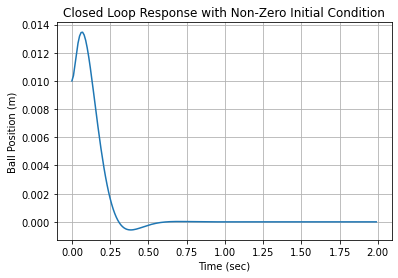

In [8]:
_, y, _ = control.forced_response(sys_cl, T=t, U=u, X0=x0)
plt.plot(t, y)
plt.title("Closed Loop Response with Non-Zero Initial Condition")
plt.xlabel("Time (sec)")
plt.ylabel("Ball Position (m)")
plt.grid("on")

The overshoot is too large (there are also zeros in the transfer function which can increase the overshoot; you do not see the zeros in the state-space formulation).  Try placing the poles further to the left to see if the transient response improves (this should also make the response faster).

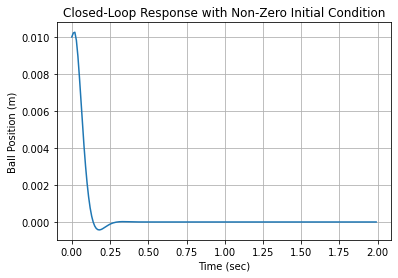

In [9]:
p1 = -20 + 20j
p2 = -20 - 20j
p3 = -100
K = control.place(A, B, [p1, p2, p3])
sys_cl = control.StateSpace(A - B * K, B, C, 0)
_, y, _ = control.forced_response(sys_cl, T=t, U=u, X0=x0)
plt.plot(t, y)
plt.title("Closed-Loop Response with Non-Zero Initial Condition")
plt.xlabel("Time (sec)")
plt.ylabel("Ball Position (m)")
plt.grid("on")

This time the overshoot is smaller. Consult your textbook for further suggestions on choosing the desired closed-loop poles.

Compare the control effort required ($u$) in both cases. In general, the farther you move the poles to the left, the more control effort is required. 

**Note**: If you want to place two or more poles at the same position, place will not work. You can use a function called acker which achieves the same goal (but can be less numerically well-conditioned): 

In [10]:
K = control.acker(A, B, [p1, p2, p3])

### Introducing the Reference Input

Now, we will take the control system as defined above and apply a step input (we choose a small value for the step, so we remain in the region where our linearization is valid).

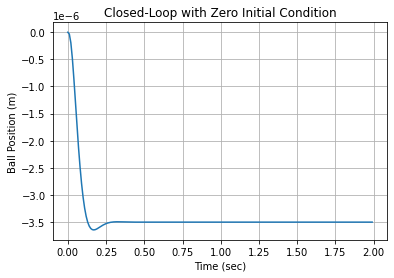

In [11]:
t = np.arange(0, 2, 0.01)
# Input step response
u = 0.001 * np.ones(np.shape(t))
#
sys_cl = control.StateSpace(A - B * K, B, C, 0)
_, y, _ = control.forced_response(sys_cl, T=t, U=u)
plt.plot(t, y)
plt.title("Closed-Loop with Zero Initial Condition")
plt.xlabel("Time (sec)")
plt.ylabel("Ball Position (m)")
plt.grid("on")

The system does not track the step well at all; not only is the magnitude not one, but it is negative instead of positive!

Recall the schematic above, we don't compare the output to the reference; instead we measure all the states, multiply by the gain vector $K$, and then subtract this result from the reference. There is no reason to expect that $K\mathbf{x}$ will be equal to the desired output. To eliminate this problem, we can scale the reference input to make it equal to $K\mathbf{x}$ in steady-state. The scale factor, $\overline{N}$, is shown in the following schematic: 


![StateSpaceTutorial_ReferenceInput_BlockDiagram.png](figures/StateSpaceTutorial_ReferenceInput_BlockDiagram.png)
We can get Nbar from Python by creating the following function `rscale`

In [12]:
def rscale(sys, K):
    """ Given the single-input linear system: 
      x = Ax + Bu
      y = Cx + Du
    and the feedback matrix K,

    the function rscale(sys,K) or rscale(A,B,C,D,K) 
    finds the scale factor N which will 
    eliminate the steady-state error to a step reference 
    for a continuous-time, single-input system
    with full-state feedback using the schematic below:

                            /---------\
         R         +     u  | .       |
         ---> N --->() ---->| X=Ax+Bu |--> y=Cx ---> y
                   -|       \\---------/
                    |             | 
                    |<---- K <----|

    8/21/96 Yanjie Sun of the University of Michigan
           under the supervision of Prof. D. Tilbury
    6/12/98 John Yook, Dawn Tilbury revised
    07-Mar-2021. Converted to Python. Jed Frey.
    
    % compute Nbar
    s = size(A,1);
    Z = [zeros([1,s]) 1];
    N = inv([A,B;C,D])*Z';
    Nx = N(1:s);
    Nu = N(1+s);
    Nbar=Nu + K*Nx;
    """
    s = A.shape[0]
    Z = np.zeros((s + 1, 1))
    Z[-1] = 1
    # Concatenate each section
    tmpa = np.concatenate((sys.A, sys.B), axis=1)
    tmpb = np.concatenate((sys.C, sys.D), axis=1)
    # Concatenate together and multiply by Z.
    N = np.linalg.inv(np.concatenate((tmpa, tmpb), axis=0)) * Z

    Nx = N[0:-1]
    Nu = N[-1]
    return Nu + K * Nx

In [13]:
Nbar = rscale(sys, K)
Nbar

matrix([[-285.71428571]])

Now, if we want to find the response of the system under state feedback with this introduction of the reference, we simply note the fact that the input is multiplied by this new factor, $\bar{N}$:

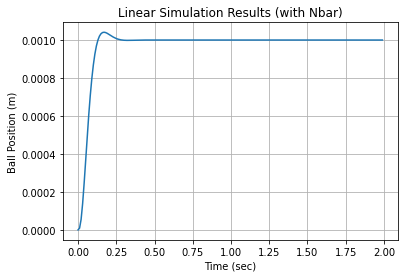

In [14]:
_, y, _ = control.forced_response(sys_cl, T=t, U=Nbar * u)
plt.plot(t, y)
plt.title("Linear Simulation Results (with Nbar)")
plt.xlabel("Time (sec)")
plt.ylabel("Ball Position (m)")
plt.grid("on")

and now a step can be tracked reasonably well. Note, our calculation of the scaling factor requires good knowledge of the system. If our model is in error, then we will scale the input an incorrect amount. An alternative, similar to what was introduced with PID control, is to add a state variable for the integral of the output error. This has the effect of adding an integral term to our controller which is known to reduce steady-state error. 

### Observer Design

When we can't measure all the states |x| (often the case in practice), we can build an **observer** to estimate them, while measuring only the output |y = C x|.  For the magnetic ball example, we will add three new, estimated states to the system.  The schematic is as follows:
![StateSpaceTutorial_ObserverDesign_BlockDiagram.png](figures/StateSpaceTutorial_ObserverDesign_BlockDiagram.png)

The observer is basically a copy of the plant; it has the same input and almost the same differential equation. An extra term compares the actual measured output $y$ to the estimated output $\hat{y} = C\hat{\mathbf{x}}$; this will help to correct the estimated state $\hat{\mathbf{x}}$ and cause it to approach the values of the actual state $\mathbf{x}$ (if the measurement has minimal error).

$$ \dot{\hat{\mathbf{x}}} = A\hat{\mathbf{x}} + Bu + L(y - \hat{y}) $$

$$ \hat{y} = C\hat{\mathbf{x}} $$

The error dynamics of the observer are given by the poles of $A-LC$.

$$ \dot{\mathbf{e}} = \dot{\mathbf{x}} - \dot{\hat{\mathbf{x}}} = (A - LC)\mathbf{e} $$

First, we need to choose the observer gain $L$. Since we want the dynamics of the observer to be much faster than the system itself, we need to place the poles at least five times farther to the left than the dominant poles of the system. If we want to use place, we need to put the three observer poles at different locations. 

In [15]:
op1 = -100
op2 = -101
op3 = -102

Because of the duality between controllability and observability, we can use the same technique used to find the control matrix by replacing the matrix $B$ by the matrix $C$ and taking the transposes of each matrix: 

In [16]:
L = control.place(A.transpose(), C.transpose(), [op1, op2, op3]).transpose()
L

matrix([[  203.        ],
        [11282.00000001],
        [   -0.        ]])

The equations in the block diagram above are given for the estimate $\hat{\mathbf{x}}$. It is conventional to write the combined equations for the system plus observer using the original state equations plus the estimation error: $\mathbf{e} = \mathbf{x} - \hat{\mathbf{x}}$. We use the estimated state for feedback, $u = -K \hat{\mathbf{x}}$, since not all state variables are necessarily measured. After a little bit of algebra (consult your textbook for more details), we arrive at the combined state and error equations for full-state feedback with an observer.

In [17]:
At1 = np.concatenate((A - B * K, B * K), axis=1)
At2 = np.concatenate((np.zeros(A.shape), A - L * C), axis=1)
At = np.concatenate((At1, At2), axis=0)
At

matrix([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 9.80000000e+02,  0.00000000e+00, -2.80000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 7.75714286e+04,  2.06428571e+03, -1.40000000e+02,
         -7.75714286e+04, -2.06428571e+03,  4.00000000e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -2.03000000e+02,  1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -1.03020000e+04,  0.00000000e+00, -2.80000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00, -1.00000000e+02]])

In [18]:
Bt = np.concatenate((B * Nbar, np.zeros(B.shape)), axis=0)
Bt

matrix([[     0.        ],
        [     0.        ],
        [-28571.42857143],
        [     0.        ],
        [     0.        ],
        [     0.        ]])

In [19]:
Ct = np.concatenate((C, np.zeros(C.shape)), axis=1)
Ct

array([[1., 0., 0., 0., 0., 0.]])

In [20]:
sys = control.StateSpace(At, Bt, Ct, 0)

In [21]:
x00 = np.concatenate((x0, x0), axis=0)

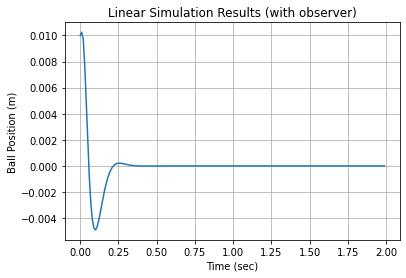

In [22]:
T, Y, xout = control.forced_response(sys, T=t, U=np.zeros(t.shape), X0=x00)
plt.plot(T, Y)
plt.title("Linear Simulation Results (with observer)")
plt.xlabel("Time (sec)")
plt.ylabel("Ball Position (m)")
plt.grid("on")

Responses of all the state variables are plotted below. Recall that lsim gives us $\mathbf{x}$ and $\mathbf{e}$; to get $\hat{\mathbf{x}}$, we need to compute $\mathbf{x} - \mathbf{e}$. 

In [23]:
t = np.arange(0, 0.1, 1e-6)
x0 = np.array([[0.01, 0.5, -5]])
x00 = np.squeeze(np.concatenate((x0, x0), axis=1))
T, Y, x = control.forced_response(sys, T=t, U=np.zeros(t.shape), X0=x00)

Save state variables explicitly to aid in plotting

In [24]:
e = x[:3, :]
x2 = x[3:, :]
x_est = x2 - e

h = x[0, :]
h_dot = x[1, :]
i = x[2, :]

h_est = x_est[0, :]
h_dot_est = x_est[1, :]
i_est = x_est[2, :]

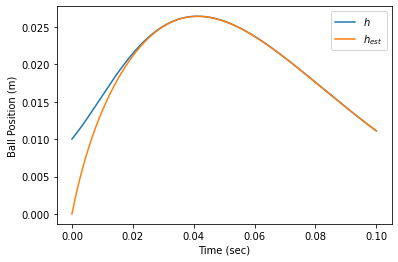

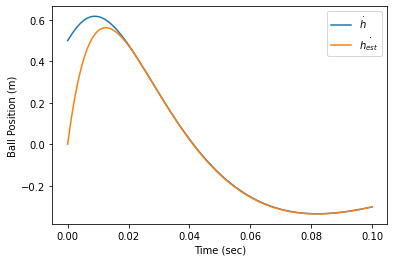

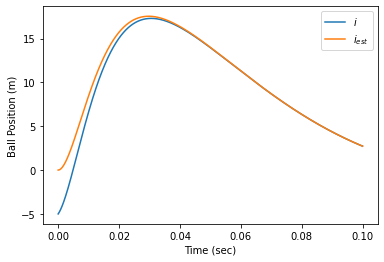

In [25]:
# todo: Figure out why these are flipped
plt.plot(t, h, t, -h_est)
plt.legend(["$h$", "$h_{est}$"])
plt.ylabel("Ball Position (m)")
plt.xlabel("Time (sec)")
plt.show()

plt.plot(t, h_dot, t, -h_dot_est)
plt.legend([r"$\dot{h}$", r"$\dot{h_{est}}$"])
plt.ylabel("Ball Position (m)")
plt.xlabel("Time (sec)")
plt.show()

plt.plot(t, i, t, -i_est)

plt.legend(["$i$", "$i_{est}$"])
plt.ylabel("Ball Position (m)")
plt.xlabel("Time (sec)")
plt.show()

From the above, we can see that the observer estimates converge to the actual state variables quickly and track the state variables well in steady-state. 